# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".

But for your assignment, i will ask you to extract education.

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("resume.csv")

In [2]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [3]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "skills.jsonl"

In [4]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [5]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Let's try to extract skills from this resume.csv

In [6]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
2152,24580361,"ASSOCIATE, INVESTMENT BANKING OPERATI...","<div class=""fontsize fontface vmargins hmargin...",BANKING
1969,15721849,CONSTRUCTION PROJECT REGIONAL MANAGER...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
1670,14304010,"KEY HOLDER, SALES PLANNER Summa...","<div class=""fontsize fontface vmargins hmargin...",APPAREL
1737,55595908,SITE ENGINEERING Career Ove...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING
1606,56151548,SUBSTITUTE TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL


In [7]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [8]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

"         MORTGAGE BANKING RESEARCH SPECIALIST       Summary    My goal is to obtain a career associated with a company where I can utilize my skills and gain further experience while enhancing the company's brand and reputation.      Highlights          5+ years of Leadership as a  Supervisor/Manage"

In [9]:
preprocessing(random_resume[:300])

'mortgage banking research specialist summary my goal obtain career associate company i utilize skill gain experience enhance company brand reputation highlight 5 + year leadership supervisor manage'

In [10]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [11]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
2152,24580361,"ASSOCIATE, INVESTMENT BANKING OPERATI...","<div class=""fontsize fontface vmargins hmargin...",BANKING,associate investment banking operation highlig...
1969,15721849,CONSTRUCTION PROJECT REGIONAL MANAGER...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction project regional manager summary ...
1670,14304010,"KEY HOLDER, SALES PLANNER Summa...","<div class=""fontsize fontface vmargins hmargin...",APPAREL,key holder sales planner summary art director ...
1737,55595908,SITE ENGINEERING Career Ove...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,site engineering career overview 10 + year tot...
1606,56151548,SUBSTITUTE TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,substitute teacher summary seek administrative...


## 4. Let's really extract skills!!

In [12]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [13]:
df_resume.head(3)

,ID,Resume_str,Resume_html,Category,Clean_resume
2152,24580361,"ASSOCIATE, INVESTMENT BANKING OPERATI...","<div class=""fontsize fontface vmargins hmargin...",BANKING,associate investment banking operation highlig...
1969,15721849,CONSTRUCTION PROJECT REGIONAL MANAGER...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction project regional manager summary ...
1670,14304010,"KEY HOLDER, SALES PLANNER Summa...","<div class=""fontsize fontface vmargins hmargin...",APPAREL,key holder sales planner summary art director ...


In [14]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [15]:
df_resume.Skills.iloc[0]

['operations management', 'database', 'business']

## 5. Visualization
​
Which skills is most important in information management?

In [16]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [17]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(50, 6)

In [18]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [19]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [20]:
counting

OrderedDict([('support', 46),
             ('software', 42),
             ('security', 35),
             ('business', 34),
             ('design', 32),
             ('database', 29),
             ('windows', 27),
             ('project management', 26),
             ('server', 25),
             ('documentation', 19)])

<BarContainer object of 10 artists>

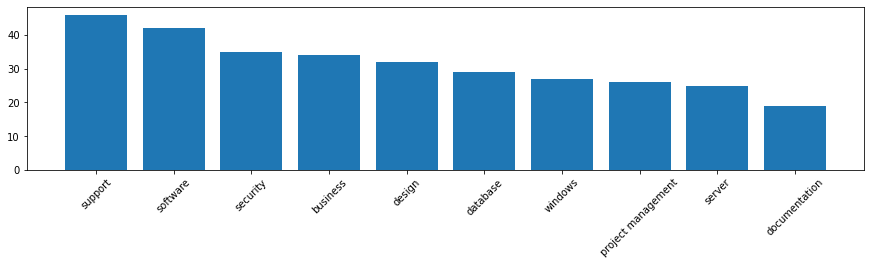

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [22]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [23]:
doc = nlp(text)

In [24]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [25]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. Let's load the PDF - add some realism

In [26]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [27]:
text = preprocessing(text)

In [28]:
doc = nlp(text)

In [29]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [30]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

{'algorithms', 'computer science', 'engineering', 'ai', 'deep learning'}


# Assignment

I can't create an web-app because of installing problems, then I can do an assignment by csv. instead. sorry for doing imcomplete assignment.

In [33]:
# convert all files into .csv file
# create dataframe from all labels
import csv
  
field_names = ['No', 'Company', 'Car Model']

label = []
resume_dct = {}
for ent in doc.ents:
    if ent.label_ not in label:
        label.append(ent.label_)
        resume_dct[ent.label_] = []
        resume_dct[ent.label_].append(ent.text)
    else:
        resume_dct[ent.label_].append(ent.text)
print(resume_dct)
row = []
with open('resume.csv', 'w+') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = label)
    writer.writeheader()
    for key in label:
        for val in resume_dct[key]:
            row.append({key:val})
    writer.writerows(row)
df_resume = pd.read_csv('resume.csv')
df_resume = df_resume.apply(lambda x : sorted(x,key=pd.isnull))
df_resume.to_csv('resume.csv') 
df_resume.head()

{'ORG': ['oshua bengio c.v département d’informatique et recherche opérationnelle université de montréal', 'royal society canada cifar ai', '\x0ffull', 'cifar', 'ccai chair', 'ministry inter- national relations francophonie', 'intelligence institute montreal institute', 'gan', 'ado data v alorization institute', 'cfref'], 'CARDINAL': ['514', '300', '35', '93.6m$'], 'DATE': ['6804', '2002', '1993', '1997 2002', '1993 1997', '2001 2019', '2018 2023 1.25m$ \x0frecipient 2018', '2019', '2017', '2019', '2018 2019', '2009', '2017', '2018', '2006', '2009', '2011', '2014', '2016 2023'], 'PERSON': ['https://mila.quebec/en/yoshua- bengio', 'université de montréal department', 'victorin québec prize', 'acfas urgel archambault', 'mila quebec', 'u. montréal hec', 'montreal mcgill', 'mila'], 'GPE': ['london'], 'SKILL': ['computer science', 'algorithms', 'ai', 'computer science', 'engineering', 'ai', 'algorithms', 'ai', 'deep learning', 'deep learning', 'deep learning'], 'NORP': ['\x0fcanada', 'canad

,ORG,CARDINAL,DATE,PERSON,GPE,SKILL,NORP,EVENT,ORDINAL
0,oshua bengio c.v département d’informatique et...,514,6804,https://mila.quebec/en/yoshua- bengio,london,computer science,canada,québec prix d’excellence du frqnt,50th
1,royal society canada cifar ai,300,2002,université de montréal department,NaN,algorithms,canadian,NaN,NaN
2,full,35,1993,victorin québec prize,NaN,ai,canadians,NaN,NaN
3,cifar,93.6m$,1997 2002,acfas urgel archambault,NaN,computer science,NaN,NaN,NaN
4,ccai chair,NaN,1993 1997,mila quebec,NaN,engineering,NaN,NaN,NaN
